In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/thames21/AIL_KNNMovieRecommendation

Cloning into 'AIL_KNNMovieRecommendation'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 881.12 KiB | 2.45 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
%cd AIL_KNNMovieRecommendation

/content/AIL_KNNMovieRecommendation


# Task 1: Data Preprocessing




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
movies_df = pd.read_csv('movies.csv',
                        usecols=['movieId', 'title'],
                        dtype={'movieId': 'int64', 'title': 'str'})
rating_df = pd.read_csv('ratings.csv',
                        usecols=['userId', 'movieId', 'rating'],
                        dtype={'userId': 'int64', 'movieId': 'int64', 'rating': 'float64'})

In [ ]:
print(movies_df.shape)
movies_df.head()

(9742, 2)


,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
print(rating_df.shape)
rating_df.head()

(100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
# Merge the two datasets
df = pd.merge(rating_df, movies_df, on='movieId')
print(df.shape)
df.head()

(100836, 4)


,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


In [ ]:
# Check for misssing values
df.isnull().sum().sum()

0

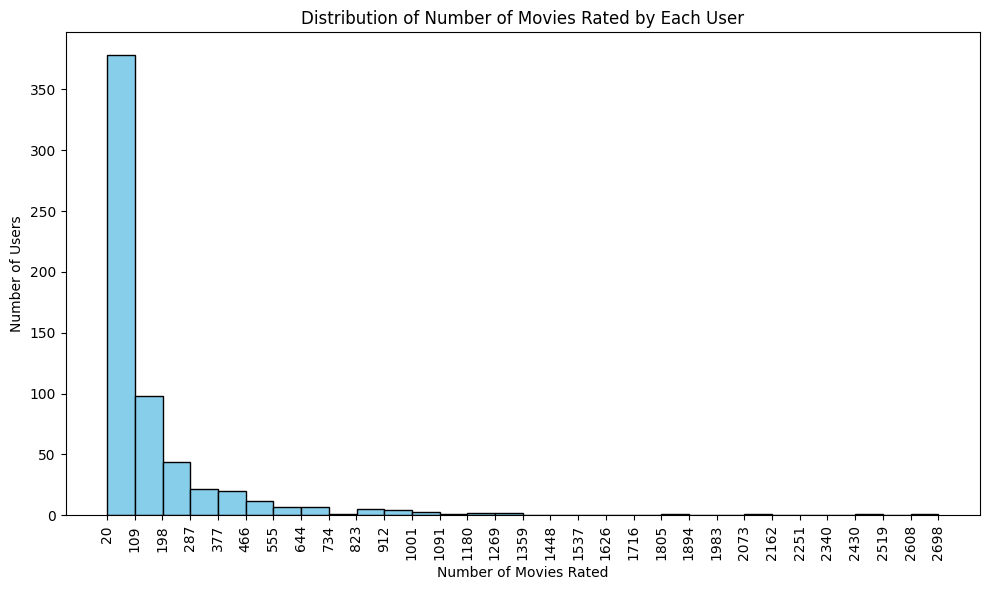

In [ ]:
# Count how many users rate how many movies
user_rating_counts = df.groupby('userId').size()

# Plot the distribution
plt.figure(figsize=(10, 6))
num_bins = 30
counts, bins, _ = plt.hist(user_rating_counts, bins=num_bins, color='skyblue', edgecolor='black')
plt.xticks(bins.astype(int), rotation=90)
plt.title('Distribution of Number of Movies Rated by Each User')
plt.xlabel('Number of Movies Rated')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Task 2: Implementation using Surprise Library

In [ ]:
pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357278 sha256=9f0e44902c0dd99b9d6dd091a4246b9899ab1786db3d6d95c092f625546e628e
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split

In [ ]:
df1 = df[['userId', 'title', 'rating']]
df1.head()

,userId,title,rating
0,1,Toy Story (1995),4.0
1,1,Grumpier Old Men (1995),4.0
2,1,Heat (1995),4.0
3,1,Seven (a.k.a. Se7en) (1995),5.0
4,1,"Usual Suspects, The (1995)",5.0


In [ ]:
reader = Reader(rating_scale=(df1['rating'].min(), rating_df['rating'].max()))
data = Dataset.load_from_df(df1[['userId', 'title', 'rating']], reader=reader)

In [ ]:
# Split the data in train set and test set
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)
trainset.n_users, trainset.n_items

(610, 8729)

## 2.1. User-based

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': True  # User-based collaborative filtering
}
algo = KNNBasic(sim_options = sim_options, verbose= True)
algo.fit(trainset)
predictions = algo.test(testset)
user_based_unfiltered = accuracy.rmse(predictions)
user_based_unfiltered

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9810


0.9810426330727836

## 2.2 Item-based

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': False
}
algo = KNNBasic(sim_options=sim_options,
               k=40,
               min_k=1,
               verbose=True)

algo.fit(trainset)
predictions = algo.test(testset)
item_based_unfiltered = accuracy.rmse(predictions)
item_based_unfiltered

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9826


0.9826329787513854

## 2.3. Evaluate on the Filtered Set

In [ ]:
combine_movie_rating = df.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,'71 (2014),1
1,'Hellboy': The Seeds of Creation (2004),1
2,'Round Midnight (1986),2
3,'Salem's Lot (2004),1
4,'Til There Was You (1997),2


In [ ]:
rating_with_totalRatingCount = combine_movie_rating.merge(movie_ratingCount,
                                                          left_on = 'title',
                                                          right_on = 'title',
                                                          how = 'left')
rating_with_totalRatingCount.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story (1995),215
1,1,3,4.0,Grumpier Old Men (1995),52
2,1,6,4.0,Heat (1995),102
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.0,"Usual Suspects, The (1995)",204


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(len(rating_with_totalRatingCount['movieId'].unique()))

9724


In [ ]:
popularity_threshold = 50
rating_popular_movie= rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
print(len(rating_popular_movie['movieId'].unique()))
rating_popular_movie.head()

451


,userId,movieId,rating,title,totalRatingCount
0,1,1,4.000,Toy Story (1995),215
1,1,3,4.000,Grumpier Old Men (1995),52
2,1,6,4.000,Heat (1995),102
3,1,47,5.000,Seven (a.k.a. Se7en) (1995),203
4,1,50,5.000,"Usual Suspects, The (1995)",204


In [ ]:
df2 = rating_popular_movie[['userId', 'title', 'rating']]
df2.head()

,userId,title,rating
0,1,Toy Story (1995),4.000
1,1,Grumpier Old Men (1995),4.000
2,1,Heat (1995),4.000
3,1,Seven (a.k.a. Se7en) (1995),5.000
4,1,"Usual Suspects, The (1995)",5.000


### 2.3.1 Item-based

In [ ]:
reader = Reader(rating_scale=(rating_popular_movie['rating'].min(), rating_popular_movie['rating'].max()))
data = Dataset.load_from_df(df2[['userId', 'title', 'rating']], reader=reader)
trainset, testset = train_test_split(data, test_size=0.25)
sim_options = {
    'name': 'cosine',
    'user_based': False
}
algo = KNNBasic(sim_options=sim_options,
               k=40,
               min_k=1,
               verbose=True)
algo.fit(trainset)
predictions = algo.test(testset)
item_based_filtered = accuracy.rmse(predictions)
item_based_filtered

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8886


0.8886445374097003

### 2.3.2 User-based

In [ ]:
reader = Reader(rating_scale=(rating_popular_movie['rating'].min(), rating_popular_movie['rating'].max()))
data = Dataset.load_from_df(df2[['userId', 'title', 'rating']], reader=reader)
trainset, testset = train_test_split(data, test_size=0.25)
sim_options = {
    'name': 'cosine',
    'user_based': True
}
algo = KNNBasic(sim_options=sim_options,
               k=40,
               min_k=1,
               verbose=True)
algo.fit(trainset)
predictions = algo.test(testset)
user_based_filtered = accuracy.rmse(predictions)
user_based_filtered

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9164


0.9164074543154436

### 2.3.3 Evaluating

In [ ]:
pd.DataFrame(data = {'Unfiltered':[user_based_unfiltered, item_based_unfiltered],
                     'Filtered':[user_based_filtered, item_based_filtered]}, index = ['User_based', 'Item_based'])

,Unfiltered,Filtered
User_based,0.981,0.916
Item_based,0.983,0.889


## 2.4. Fine-tuning

In [ ]:
reader = Reader(rating_scale=(rating_popular_movie['rating'].min(), rating_popular_movie['rating'].max()))
data = Dataset.load_from_df(df2[['userId', 'title', 'rating']], reader=reader)
trainset, testset = train_test_split(data, test_size=0.25)
minRMSE = {'user':100, 'item':100}
k = [20, 30, 40, 50, 60]
min_k = [1, 2, 3, 4, 5]
bestMaxK = [-10,-10]
bestMinK = [100, 100]
for i in k:
  for j in min_k:
    for user_based in (True, False):
      sim_options = {
      'name': 'cosine',
      'user_based': user_based
  }
      algo = KNNBasic(sim_options=sim_options,
                    k=i,
                    min_k=j,
                    verbose=False)
      algo.fit(trainset)
      predictions = algo.test(testset)
      a = accuracy.rmse(predictions)
      if user_based == True:
        if minRMSE['user'] > a:
          minRMSE['user'] = a
          bestMaxK[0] = i
          bestMinK[0] = j
      else:
        if minRMSE['item'] > a:
          minRMSE['item'] = a
          bestMaxK[1] = i
          bestMinK[1] = j
print(f"User: {minRMSE['user']} with k = {bestMaxK[0]} and min_k = {bestMinK[0]}")
print(f"Item: {minRMSE['item']} with k = {bestMaxK[1]} and min_k = {bestMinK[1]}")


RMSE: 0.9109
RMSE: 0.8765
RMSE: 0.9109
RMSE: 0.8766
RMSE: 0.9109
RMSE: 0.8768
RMSE: 0.9109
RMSE: 0.8769
RMSE: 0.9109
RMSE: 0.8771
RMSE: 0.9033
RMSE: 0.8780
RMSE: 0.9033
RMSE: 0.8781
RMSE: 0.9033
RMSE: 0.8783
RMSE: 0.9033
RMSE: 0.8784
RMSE: 0.9033
RMSE: 0.8786
RMSE: 0.9021
RMSE: 0.8800
RMSE: 0.9021
RMSE: 0.8801
RMSE: 0.9021
RMSE: 0.8803
RMSE: 0.9021
RMSE: 0.8804
RMSE: 0.9021
RMSE: 0.8806
RMSE: 0.9023
RMSE: 0.8822
RMSE: 0.9023
RMSE: 0.8823
RMSE: 0.9023
RMSE: 0.8825
RMSE: 0.9023
RMSE: 0.8826
RMSE: 0.9023
RMSE: 0.8828
RMSE: 0.9025
RMSE: 0.8832
RMSE: 0.9025
RMSE: 0.8832
RMSE: 0.9025
RMSE: 0.8834
RMSE: 0.9025
RMSE: 0.8835
RMSE: 0.9025
RMSE: 0.8837
User: 0.9020661319845216 with k = 40 and min_k = 4
Item: 0.876531582405084 with k = 20 and min_k = 1


# Task 3: Implementation using numpy, pandas and sklearn

In [ ]:
from sklearn.metrics import pairwise_distances, root_mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data into training and testing sets
# trainset, testset = train_test_split(df, test_size=0.25, random_state=42)

df4 is generated from the filtered dataset n>=50

In [ ]:
df4 = rating_popular_movie[['userId', 'movieId',  'rating', 'title']]
df4.head()

,userId,movieId,rating,title
0,1,1,4.000,Toy Story (1995)
1,1,3,4.000,Grumpier Old Men (1995)
2,1,6,4.000,Heat (1995)
3,1,47,5.000,Seven (a.k.a. Se7en) (1995)
4,1,50,5.000,"Usual Suspects, The (1995)"


In [ ]:
trainset, testset = train_test_split(df4, test_size = 0.25, random_state=42)

## 3.1. User-based

In [ ]:
# Prepare the interaction matrix for user-based filtering
interaction_matrix = trainset.pivot(index='userId', columns='movieId', values='rating')
interaction_matrix.fillna(0, inplace=True)

interaction_matrix

movieId,1,2,3,6,7,10,11,16,17,19,...,91500,91529,96079,99114,106782,109374,109487,112852,116797,122904
userId,,,,,,,,,,,,,,,,,,,,,
1,4.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,3.500,0.000,0.000,3.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.500,0.000,0.000,0.000,2.500,0.000,2.500,0.000,4.000,0.000,...,4.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
607,0.000,0.000,0.000,0.000,0.000,0.000,3.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
608,0.000,2.000,2.000,0.000,0.000,0.000,0.000,4.500,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [ ]:
# User-based similarity matrix using cosine similarity
user_similarity = 1 - pairwise_distances(interaction_matrix, metric="cosine")
np.fill_diagonal(user_similarity, 0)  # Avoid self-similarity

# Convert to DataFrame
user_similarity = pd.DataFrame(user_similarity, index=interaction_matrix.index, columns=interaction_matrix.index)
user_similarity

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.043,0.117,0.365,0.204,0.171,0.140,0.121,0.124,0.028,...,0.134,0.215,0.391,0.109,0.245,0.338,0.304,0.328,0.188,0.260
2,0.043,0.000,0.000,0.000,0.042,0.059,0.000,0.000,0.000,0.096,...,0.096,0.045,0.000,0.000,0.000,0.049,0.000,0.048,0.000,0.151
3,0.117,0.000,0.000,0.000,0.060,0.000,0.000,0.000,0.000,0.000,...,0.038,0.000,0.000,0.000,0.000,0.038,0.034,0.089,0.000,0.014
4,0.365,0.000,0.000,0.000,0.115,0.107,0.161,0.064,0.033,0.006,...,0.138,0.142,0.331,0.113,0.161,0.243,0.278,0.263,0.058,0.211
5,0.204,0.042,0.060,0.115,0.000,0.296,0.105,0.397,0.000,0.040,...,0.130,0.407,0.161,0.331,0.218,0.167,0.216,0.192,0.359,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.338,0.049,0.038,0.243,0.167,0.151,0.312,0.086,0.153,0.169,...,0.278,0.156,0.415,0.128,0.300,0.000,0.246,0.482,0.086,0.428
607,0.304,0.000,0.034,0.278,0.216,0.162,0.202,0.156,0.030,0.025,...,0.114,0.239,0.268,0.113,0.211,0.246,0.000,0.343,0.208,0.252
608,0.328,0.048,0.089,0.263,0.192,0.240,0.363,0.179,0.091,0.138,...,0.199,0.266,0.422,0.220,0.248,0.482,0.343,0.000,0.104,0.476


In [ ]:
# Define a function to find k nearest neighbors (this same function is used for item-based filtering too)
def get_k_nearest_neighbors(id, similarity_df, k):
    # Get the similarity scores between the target id and other ids
    similarity_scores = similarity_df.loc[id]       # Get the row

    # Sort the similarity scores in descending order and get the top k ids
    nearest_neighbors = similarity_scores.sort_values(ascending=False).head(k).index        # This index is custom index, not automatic numbering

    return nearest_neighbors.tolist()

In [ ]:
# Create a dictionary for k nearest neighbors for users
k = 10
user_neighbors = {}

# Iterate over each user
for user_id, _ in user_similarity.iterrows():
    user_neighbors[user_id] = get_k_nearest_neighbors(user_id, user_similarity, k)

user_neighbors[1]

[469, 57, 202, 480, 590, 368, 274, 599, 514, 474]

In [ ]:
# Define function to predict rating for user-based collaborative filtering
def user_based_rating_prediction(user_id, movie_id):
    sim_sum = 0
    weighted_sum = 0

    # Find the neighbors of the user
    neighbors = user_neighbors.get(user_id)

    # Iterate over the neighbors
    for neighbor in neighbors:
        # Find the similarity score in the user_similarity matrix
        sim = user_similarity.loc[user_id, neighbor]
        # Find the rating of the neighbor for that movie in the interaction matrix
        rating = interaction_matrix.loc[neighbor, movie_id]

        if rating > 0:
            sim_sum += sim
            weighted_sum += sim * rating

    if sim_sum != 0:
        rounded_rating = round(weighted_sum / sim_sum * 2) / 2      # Round to the nearest 0.5
        return rounded_rating
    else:
        return 0

In [ ]:
user_based_pred = []

# Generate prediction for the test set
for user_id, movie_id in zip(testset['userId'], testset['movieId']):
    # If we already have data about the userId and movieId from the trainset, we can predict
    if user_id in interaction_matrix.index and movie_id in interaction_matrix.columns:
        pred = user_based_rating_prediction(user_id, movie_id)
    # Else if we have no info about the userId or movieId, we cannot predict
    else:
        pred = 0

    user_based_pred.append(pred)

In [ ]:
# Calculate the rmse
true_ratings = testset['rating'].tolist()
rmse = root_mean_squared_error(true_ratings, user_based_pred)
print(f"User-Based Filtering RMSE: {rmse}")

User-Based Filtering RMSE: 1.194495886789367


In [ ]:
# Save to CSV file
comparison = pd.DataFrame({'True Rating': true_ratings, 'Predicted Rating': user_based_pred})
comparison.to_csv('user_based_ratings.csv', index=False)

## 3.2. Item-based

In [ ]:
# Transpose the interaction matrix for item-based filtering
transpose_interaction_matrix = interaction_matrix.T
transpose_interaction_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.000,0.000,0.000,0.000,4.000,0.000,4.500,0.000,0.000,0.000,...,4.000,0.000,4.000,3.000,4.000,2.500,0.000,0.000,3.000,5.000
2,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,...,0.000,4.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,5.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000
6,4.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,...,0.000,3.000,4.000,3.000,0.000,0.000,0.000,0.000,0.000,5.000
7,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,2.500,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.500
109487,0.000,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.500,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,3.500
112852,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4.500


In [ ]:
# Item-based similarity matrix using cosine similarity
movie_similarity = 1 - pairwise_distances(transpose_interaction_matrix, metric="cosine")
np.fill_diagonal(movie_similarity, 0)  # Avoid self-similarity

# Convert to DataFrame
movie_similarity = pd.DataFrame(movie_similarity, index=transpose_interaction_matrix.index, columns=transpose_interaction_matrix.index)
movie_similarity

movieId,1,2,3,6,7,10,11,16,17,19,...,91500,91529,96079,99114,106782,109374,109487,112852,116797,122904
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.000,0.360,0.267,0.285,0.273,0.351,0.274,0.241,0.243,0.346,...,0.208,0.175,0.214,0.147,0.152,0.185,0.154,0.213,0.129,0.188
2,0.360,0.000,0.259,0.189,0.182,0.341,0.307,0.190,0.133,0.311,...,0.210,0.216,0.181,0.157,0.154,0.153,0.145,0.181,0.122,0.234
3,0.267,0.259,0.000,0.205,0.315,0.249,0.194,0.173,0.106,0.252,...,0.031,0.000,0.052,0.000,0.054,0.030,0.014,0.019,0.030,0.052
6,0.285,0.189,0.205,0.000,0.141,0.273,0.242,0.463,0.160,0.231,...,0.087,0.123,0.106,0.129,0.127,0.169,0.100,0.078,0.125,0.099
7,0.273,0.182,0.315,0.141,0.000,0.177,0.243,0.063,0.233,0.192,...,0.098,0.025,0.064,0.029,0.025,0.019,0.000,0.042,0.008,0.031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109374,0.185,0.153,0.030,0.169,0.019,0.047,0.063,0.209,0.054,0.104,...,0.263,0.415,0.353,0.471,0.447,0.000,0.382,0.321,0.454,0.292
109487,0.154,0.145,0.014,0.100,0.000,0.061,0.000,0.133,0.015,0.147,...,0.310,0.447,0.322,0.463,0.351,0.382,0.000,0.378,0.461,0.326
112852,0.213,0.181,0.019,0.078,0.042,0.064,0.060,0.092,0.042,0.107,...,0.324,0.325,0.428,0.288,0.368,0.321,0.378,0.000,0.411,0.471


In [ ]:
# Create a dictionary for k nearest neighbors for the movies
k = 10
movie_neighbors = {}

# Iterate over each movie
for movie_id, _ in movie_similarity.iterrows():
    movie_neighbors[movie_id] = get_k_nearest_neighbors(movie_id, movie_similarity, k)

movie_neighbors[1]

[588, 1073, 780, 260, 480, 1265, 595, 356, 3114, 364]

In [ ]:
# Define function to predict rating for item-based collaborative filtering
def item_based_rating_prediction(movie_id, user_id):
    sim_sum = 0
    weighted_sum = 0

    # Find the neighbors of the movie
    neighbors = movie_neighbors.get(movie_id)

    # Iterate over the neighbors
    for neighbor in neighbors:
        # Find the similarity score in the movie_similarity matrix
        sim = movie_similarity.loc[movie_id, neighbor]
        # Find the rating of the neighbor for that movie in the interaction matrix
        rating = transpose_interaction_matrix.loc[neighbor, user_id]

        if rating > 0:
            sim_sum += sim
            weighted_sum += sim * rating

    if sim_sum != 0:
        rounded_rating = round(weighted_sum / sim_sum * 2) / 2      # Round to the nearest 0.5
        return rounded_rating
    else:
        return 0

In [ ]:
item_based_pred = []

# Generate prediction for the test set
for user_id, movie_id in zip(testset['userId'], testset['movieId']):
    # If we already have data about the userId and movieId from the trainset
    if user_id in interaction_matrix.index and movie_id in interaction_matrix.columns:
        pred = item_based_rating_prediction(movie_id, user_id)
    # Else if we have no info about the userId or movieId, we cannot predict:
    else:
        pred = 0

    item_based_pred.append(pred)

In [ ]:
# Calculate the rmse
true_ratings = testset['rating'].tolist()
rmse = root_mean_squared_error(true_ratings, item_based_pred)
print(f"Item-Based Filtering RMSE: {rmse}")

Item-Based Filtering RMSE: 1.2902077023830918


In [ ]:
# Save to CSV file
comparison = pd.DataFrame({'True Rating': true_ratings, 'Predicted Rating': item_based_pred})
comparison.to_csv('item_based_ratings.csv', index=False)

# Task 4: Recommend best 5 movies (Extra)

In [ ]:
import random

def recommend_best_5_movies(user_id):
    # Check if we have info about the user from our interaction matrix
    if user_id in interaction_matrix.index:

        # Set to keep track of movieIds that have already been recommended
        recommended_movie_ids = set()

        # Find 5 nearest neighbors of the user
        neighbors_of_user = get_k_nearest_neighbors(user_id, user_similarity, 5)

        # Iterate over each neighbor
        for neighbor in neighbors_of_user:

            # Get the row of ratings of the neighbor
            user_ratings = interaction_matrix.loc[neighbor]

            # Get the movieIds with the highest rating
            highest_rated_movie_ids = user_ratings[user_ratings == user_ratings.max()].index.tolist()

            # Filter out already recommended movieIds
            available_movie_ids = [movie_id for movie_id in highest_rated_movie_ids if movie_id not in recommended_movie_ids]

            # Sample a random movieId from the available list
            best_movie_id = random.choice(available_movie_ids)

            # Add the selected movieId to the recommended set
            recommended_movie_ids.add(best_movie_id)

            # Get the title of the movie
            title = df4.loc[df4['movieId'] == best_movie_id, 'title'].values[0]

            print(title)

    else:
        return f'We have no info about user {user_id}'

In [ ]:
# Example: Recommend best 5 movies for userid 1
recommend_best_5_movies(1)

North by Northwest (1959)
Citizen Kane (1941)
Reservoir Dogs (1992)
Godfather: Part II, The (1974)
Lord of the Rings: The Two Towers, The (2002)
